Necessary imports.

In [1]:
from collections import deque
from keras import layers, models, optimizers
from keras import backend
import numpy as np
import copy
import sys
import gym

# Getting enviroment
env = gym.make('MountainCarContinuous-v0')

/Users/aclaudioquiros/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
print(env.__dict__)
print(env.action_space.shape[0])
print(env.observation_space.__dict__)
env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state)
print(env.action_space.sample())

{'env': <gym.envs.classic_control.continuous_mountain_car.Continuous_MountainCarEnv object at 0x112706e80>, 'action_space': Box(1,), 'observation_space': Box(2,), 'reward_range': (-inf, inf), 'metadata': {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}, '_max_episode_seconds': None, '_max_episode_steps': 999, '_elapsed_steps': 0, '_episode_started_at': None}
1
{'low': array([-1.2 , -0.07], dtype=float32), 'high': array([0.6 , 0.07], dtype=float32), 'shape': (2,), 'dtype': dtype('float32')}
[-0.59344169  0.00067136]
[0.43037874]


Define the Experience Replay Memory buffer:

In [3]:
class ExperienceReplayBuffer:
    def __init__(self, capacity, batch_size):
        self.batch_size = batch_size
        self.mem = deque(maxlen=capacity)
        
    def add_env_reaction(self, env_reaction):
        # St, At, Rt1, Dt, St1.
        self.mem.append(env_reaction)
    
    def sample_batch(self, debug=False):
        indexes = np.random.choice(a=np.arange(len(self.mem)), size=self.batch_size, replace=False)
        if debug: print(indexes)
        states = list()
        actions = list()
        rewards = list()
        dones = list()
        next_states = list()
        for index in indexes:
            st, at, rt, dt, st_1 = self.mem[index]
            states.append(st)
            actions.append(at)
            rewards.append(rt)
            dones.append(dt)
            next_states.append(st_1)      
        return np.array(states, dtype=np.float32), np.array(actions, dtype=np.float32), \
                np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.uint8), \
                np.array(next_states, dtype=np.float32)


### Testing memory

In [4]:

# Initliaze memory
def populate_memory(env, exp_replay_memory, batch_size_Q, debug=False):
    if debug: 
        print('Order of enviroment reactions')
    content = 0
    s_t1 = env.reset()
    while content < 2*batch_size_Q:
        s_t = s_t1 
        a_t = env.action_space.sample()
        s_t1, r_t1, done, info = env.step(a_t)
        if done:
            s_t1 = np.zeros(s_t.shape)
            if debug: 
                print(content, s_t1)
            exp_replay_memory.add_env_reaction((s_t, a_t, r_t1, done, s_t1))
            s_t = env.reset()
        else:
            if debug: 
                print(content, s_t1)
            exp_replay_memory.add_env_reaction((s_t, a_t, r_t1, done, s_t1))
        content += 1
    return exp_replay_memory

memory_size = 100000
batch_size_Q = 3

# Intantiate memory and populate
exp_replay = ExperienceReplayBuffer(memory_size, batch_size_Q)
exp_replay = populate_memory(env, exp_replay, batch_size_Q, debug=True)

print('Random sample from Memory Buffer')
states, actions, rewards, dones, next_states = exp_replay.sample_batch(debug=True)
for state in next_states:
    print(state)

Order of enviroment reactions
0 [-0.57451226  0.0006938 ]
1 [-0.57330344  0.00120882]
2 [-0.57195226  0.00135119]
3 [-0.56980201  0.00215025]
4 [-0.56749358  0.00230843]
5 [-0.56368157  0.00381201]
Random sample from Memory Buffer
[1 4 5]
[-0.57330346  0.00120882]
[-0.56749356  0.00230843]
[-0.56368154  0.00381201]


### Ornstein–Uhlenbeck process definition for exploration:

In [5]:
class OUNoise:
    def __init__(self, action_space, mean, sigma, theta):
        self.mean = mean*np.ones(action_space)
        self.sigma = sigma
        self.theta = theta
        self.restart()
        
    def restart(self):
        self.current = copy.copy(self.mean)
        
    def sample(self):
        x = self.current
        dx = self.theta*(self.mean-x) + self.sigma*np.random.randn(len(x))
        
        self.current = x+dx
        return x+dx

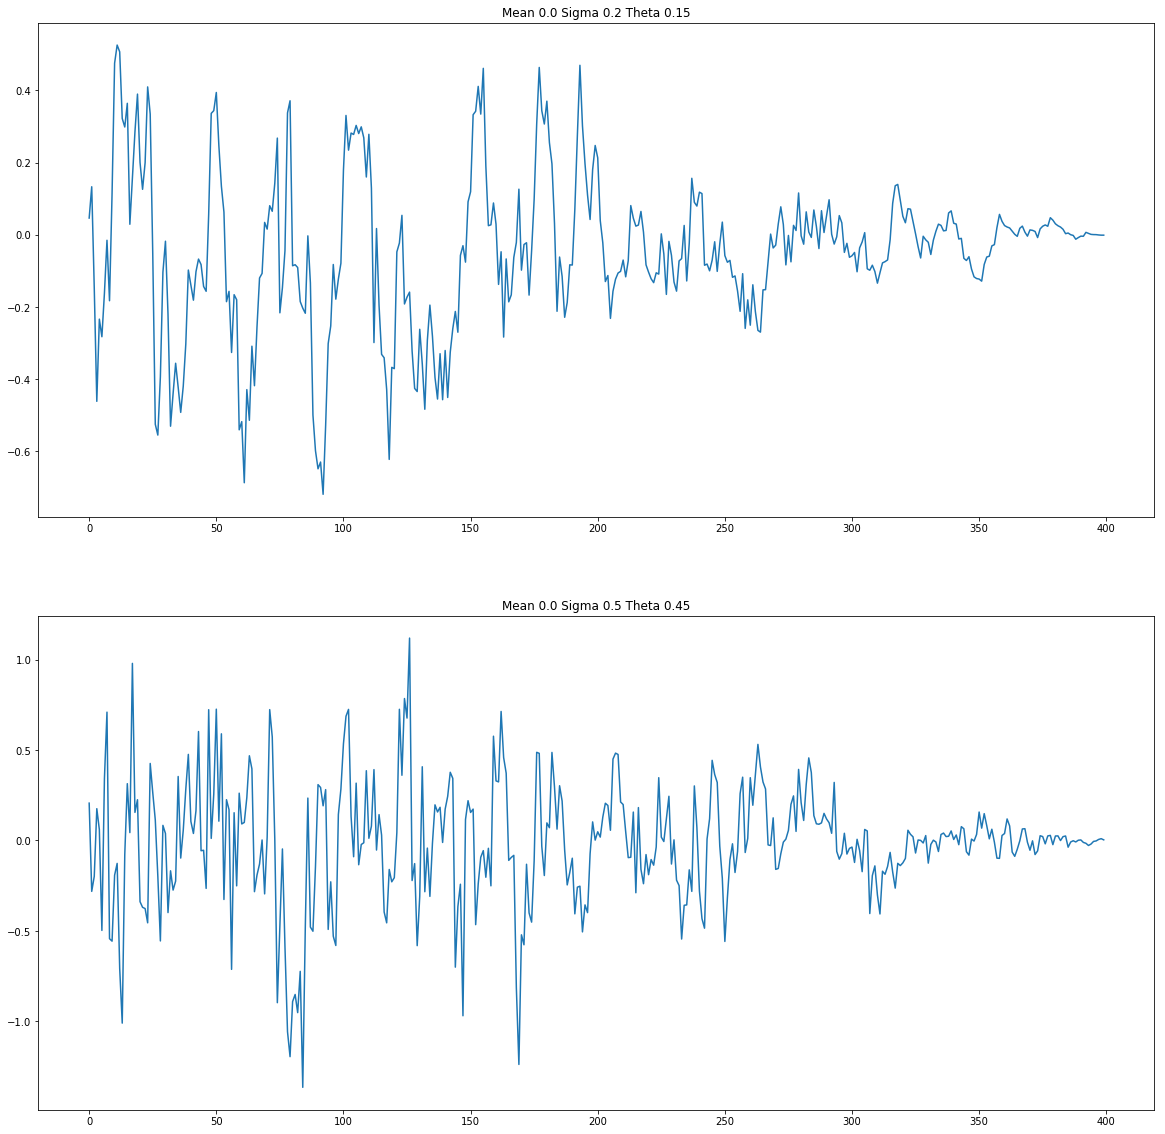

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.figsize"] = 20, 20


tests = list()
# mean, sigma, theta
tests.append((0.,0.2,0.15))
tests.append((0.,0.5,0.45))
samples = 400

noises = list()
for mean, sigma, theta in tests:
    noise = list()
    ounoise = OUNoise(env.action_space.shape[0], mean, sigma, theta)
    for episode in range(samples):
        epsilon = (float(samples)-episode)/float(samples)
        noise.append(ounoise.sample()*epsilon)
    noises.append((noise, (mean, sigma, theta)))

fig = plt.figure()
figures = len(noises)
for ind, (noise, (mean, sigma, theta)) in enumerate(noises):
    ax = fig.add_subplot('%s1%s' % (figures, ind+1))
    ax.set_title('Mean %s Sigma %s Theta %s' % (mean, sigma, theta))
    ax.plot(noise)
    



### Actor:
    Define NN for policy approximation and specify loss, backprop with action gradients dL/dA from Critc.

In [7]:
class Actor:
    def __init__(self, state_space, action_space, action_range, action_min, hidden_units, learning_rate, name):
        self.state_space = state_space
        self.action_space = action_space
        self.action_range = action_range
        self.action_min = action_min
        self.name = name
        
        # Neural Network definition.
        
        # Network Architecture.
        input_states = layers.Input(shape=(self.state_space,), dtype=np.float32, name='input_states')
        fc1 = layers.Dense(units=hidden_units, activation='relu', name='fc1')(input_states)
        fc2 = layers.Dense(units=2*hidden_units, activation='relu', name='fc2')(fc1)
        fc3 = layers.Dense(units=hidden_units, activation='relu', name='fc3')(fc2)
        
        # Todo, try different network arhitectures.
        
        # Sigmoid action, paper uses 'tanh', should be the same, more convinient for scaling.
        norm_action = layers.Dense(self.action_space, activation='sigmoid', name='norm_action')(fc3)
        
        # Adapt actions for the range in which rotors work.
        actions = layers.Lambda(lambda x: (x*self.action_range) + action_min, name='actions')(norm_action)
        
        # Instantiate Model.
        self.actor_model = models.Model(input=input_states, output=actions)
        
        # Define Loss
        input_act_grad = layers.Input(shape=(self.action_space,), dtype=np.float32, name='input_act_grad')
        loss = backend.mean(-input_act_grad*actions)
        
        # Get trainable parameters and define backprop optimization.
        adam_optimizer = optimizers.Adam(lr=learning_rate)
        train_param = adam_optimizer.get_updates(params=self.actor_model.trainable_weights, loss=loss)
        # keras.backend.learning_phase() gives a flag to be passed as input
        # to any Keras function that uses a different behavior at train time and test time.
        self.train_nn = backend.function(\
                                         inputs=[input_states, input_act_grad, backend.learning_phase()],\
                                         outputs=[], \
                                         updates=train_param)
        

### Critic:
    Define NN for Action value approximation and specify action gradients dL/dA to pass to Actor.

In [8]:
class Critic:
    def __init__(self, state_space, action_space, hidden_units, learning_rate, name):
        self.state_space = state_space
        self.action_space = action_space
        self.hidden_units = hidden_units
        self.name = name
        
        # Network Architecture.
        
        # States.
        input_states = layers.Input(shape=(self.state_space,), dtype=np.float32, name='input_states')
        fc_states1 = layers.Dense(units=hidden_units, activation='relu')(input_states)
        fc_states2 = layers.Dense(units=2*hidden_units, activation='relu')(fc_states1)
        
        # Actions.
        input_actions = layers.Input(shape=(self.action_space,), dtype=np.float32, name='input_actions')
        fc_actions1 = layers.Dense(units=hidden_units, activation='relu')(input_actions)
        fc_actions2 = layers.Dense(units=2*hidden_units, activation='relu')(fc_actions1)
        
        # Advantage function.
        fc_sa1 = layers.Add()([fc_states2, fc_actions2])
        fc_sa2 = layers.Activation('relu')(fc_sa1)
        
        # Q values output
        q_values = layers.Dense(units=1, name='q_values')(fc_sa2)
        
        # Instantiate the model
        self.critic_model = models.Model(inputs=[input_states, input_actions], outputs=q_values)
        
        # Optimizer and Loss.
        adam_optimizer = optimizers.Adam(lr=learning_rate)
        self.critic_model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
        
        # Define function to get action gradients.
        action_gradients = backend.gradients(loss=q_values, variables=input_actions)
        self.get_action_gradients = backend.function(\
                                                     inputs=[*self.critic_model.input, backend.learning_phase()], \
                                                     outputs=action_gradients)

### Deep Deterministic Policy Gradient, DDPG Agent:
    Agent definition following DDPG

In [9]:
class DDPG_Agent:
    def __init__(self, task, noise, memory, rl_param, nn_hidden, actor_lr, critic_lr):
        # Adapted for this gym
        self.task = task
        self.action_low = task.action_space.low[0]
        self.action_high = task.action_space.high[0]
        self.state_space = task.observation_space.shape[0]
        self.action_space = task.action_space.shape[0]
        
        # Instantiate Actors and Critics.
        self.actor = Actor(self.state_space, self.action_space, self.action_high-self.action_low, self.action_low,\
                          hidden_units=nn_hidden[0], learning_rate=actor_lr, name='actor')
        self.actor_target = Actor(self.state_space, self.action_space, self.action_high-self.action_low, \
                                  self.action_low, hidden_units=nn_hidden[0], learning_rate=actor_lr, \
                                  name='actor_target')  
        
        self.critic = Critic(self.state_space, self.action_space, hidden_units=nn_hidden[1], \
                            learning_rate=critic_lr, name='critic')
        self.critic_target = Critic(self.state_space, self.action_space, hidden_units=nn_hidden[1], \
                            learning_rate=critic_lr, name='critic_target')
        
        # Set same weights in target.
        self.actor_target.actor_model.set_weights(self.actor.actor_model.get_weights())
        self.critic_target.critic_model.set_weights(self.critic.critic_model.get_weights())
        
        # Noise for exploration.
        self.mean = noise[0]
        self.sigma = noise[1]
        self.theta = noise[2]
        self.ounoise = OUNoise(self.action_space, self.mean, self.sigma, self.theta)
        
        # Experience Replay memory.
        self.capacity = memory[0]
        self.batch_size = memory[1]
        self.er_buffer = ExperienceReplayBuffer(capacity=self.capacity, batch_size=self.batch_size)
        
        # RL parameters.
        self.gamma = rl_param[0]
        self.t = rl_param[1]
        
        # Keeping track of learning.
        self.learning_rewards = list()
        self.total_reward = None
        self.best_reward = -np.inf
        self.losses = list()
        
        #Learning iter.
        self.learn_iter = 0
        
    def restart_task(self):
        if self.total_reward is not None:
            self.learning_rewards.append(self.total_reward)
            if self.total_reward > self.best_reward: self.best_reward = self.total_reward
        self.total_reward = 0
        self.state = self.task.reset()
        self.ounoise.restart()
        return self.state
        
    def act(self, state, epsilon):
        self.action_wo_noise = self.actor.actor_model.predict(np.reshape(state, newshape=(-1, self.state_space)))
        self.step_noise = self.ounoise.sample()*epsilon
        action = self.action_wo_noise[0] + self.step_noise
        return np.clip(action, self.action_low, self.action_high)
        
    # Saves expirience into memory and updates actor-critic weights.
    def store_learn(self, state, action, reward, done, next_state):
        
        # Store experience into exp replay memory.
        self.er_buffer.add_env_reaction((state, action, reward, done, next_state))
        
        # Learn if agent has enough experiences.
        if len(self.er_buffer.mem) > self.batch_size:
            self.learn()
        
        self.total_reward += reward
        # Update to the current state of the enviroment.
        self.state = next_state
     
    def soft_update(self):
        actor_current = np.array(self.actor.actor_model.get_weights())
        critic_current = np.array(self.critic.critic_model.get_weights())
        actor_target = np.array(self.actor_target.actor_model.get_weights())
        critic_target = np.array(self.critic_target.critic_model.get_weights())
        
        self.actor_target.actor_model.set_weights(actor_target*(1-self.t) + self.t*actor_current)
        self.critic_target.critic_model.set_weights(critic_target*(1-self.t) + self.t*critic_current)
    
    # Learn step of the agent, update weights of actor-critic and actor-critic target NN.
    def learn(self):
        states, actions, rewards, dones, next_states = self.er_buffer.sample_batch()
        
        # Get action for deterministic policy.
        next_actions = self.actor_target.actor_model.predict_on_batch(next_states)
        next_q_values = self.critic_target.critic_model.predict_on_batch([next_states, next_actions])
        next_q_values = next_q_values.reshape((self.batch_size,))
        
        # Getting gradients before Critics backprop.
        action_gradients = self.critic.get_action_gradients([states, actions, 0])
        action_gradients = action_gradients[0].reshape((self.batch_size, self.action_space))
                
        # Need to handle the done case.
        targets = rewards + self.gamma*next_q_values*(1-dones)
        loss = self.critic.critic_model.train_on_batch(x=[states, actions],y=targets)
        self.losses.append(loss)
        
        # Learning Phase = 0 (Test), we just want the gradient, no update on weights.
        self.actor.train_nn([states, action_gradients, 1])
        
        # Do soft update on weigths.
        self.soft_update()
        
        

Function to track progress per episode:

In [10]:
import csv

def track_quad(task, labels, action):
    results = {x : [] for x in labels}
    line = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
    for ii in range(len(labels)):
            results[labels[ii]].append(line[ii])
    return line


### Run agent on the enviroment:

In [ ]:
# Labels for reporting
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity', \
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity', \
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']

# Experience Replay memory.
capacity = 100000
batch_size = 64
memory = [capacity, batch_size]

# Noise for exploration.
mean = 0
sigma = 0.2
theta = 0.15
noise = [mean, sigma, theta]

# NN sizes. Depth for actor is larger, is it possible that I need a smaller step size to stabilize?
actor_lr = 1e-4
critic_lr = 1e-3
actor_hidden = 128
critic_hidden = 128
nn_hidden = [actor_hidden, critic_hidden]

# RL parameters.
num_episodes = 1000
gamma = 0.99
t = 0.001
rl_param = [gamma, t]

quadcopter_agent = DDPG_Agent(env, noise, memory, rl_param, nn_hidden, actor_lr, critic_lr)

/Users/aclaudioquiros/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [ ]:
for episode in range(1, num_episodes+1):
    state = quadcopter_agent.restart_task()
    done = False
    epsilon = 1./(1+(episode/200))
#     epsilon = (float(num_episodes)-episode)/float(num_episodes)
    while not done:
        env.render()
        action = quadcopter_agent.act(state, epsilon)
#         print('=====STEP=====')
#         print('State', state)
#         print('Action wo noise', quadcopter_agent.action_wo_noise)
#         print('Action Noise', quadcopter_agent.step_noise)
        
        next_state, reward, done, info = env.step(action)
        quadcopter_agent.store_learn(state, action, reward, done, next_state)
        state = next_state
        
    print("Episode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}, epsilon = {}".format(
            episode, quadcopter_agent.total_reward, quadcopter_agent.best_reward, \
            quadcopter_agent.step_noise, epsilon))

Episode =    1, score = -23.843 (best =    -inf), noise_scale = [0.36574737], epsilon = 0.9950248756218907
Episode =    2, score = -22.730 (best = -23.843), noise_scale = [0.04941944], epsilon = 0.9900990099009901
Episode =    3, score = -15.592 (best = -22.730), noise_scale = [0.91650258], epsilon = 0.9852216748768474
Episode =    4, score =  91.852 (best = -15.592), noise_scale = [0.20709063], epsilon = 0.9803921568627451
Episode =    5, score =  89.251 (best =  91.852), noise_scale = [0.11043164], epsilon = 0.9756097560975611
Episode =    6, score = -76.601 (best =  91.852), noise_scale = [-0.78449765], epsilon = 0.970873786407767
Episode =    7, score = -72.618 (best =  91.852), noise_scale = [0.11797997], epsilon = 0.9661835748792271
Episode =    8, score = -79.454 (best =  91.852), noise_scale = [-0.58146429], epsilon = 0.9615384615384615
Episode =    9, score = -71.480 (best =  91.852), noise_scale = [0.20246638], epsilon = 0.9569377990430623
Episode =   10, score = -70.053 (bes

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = 20, 10
plt.plot(quadcopter_agent.losses)
plt.xlabel('Episode')
plt.ylabel('Loss')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = 20, 10
plt.plot(quadcopter_agent.learning_rewards)

plt.xlabel('Episode')
plt.ylabel('Loss')

In [ ]:
import itertools
from mpl_toolkits.mplot3d import Axes3D

# Code to get an approximate plot for the Q values.
positions = np.linspace(start=env.observation_space.low[0], stop=env.observation_space.high[0], num=100)
velocities = np.linspace(start=env.observation_space.low[1], stop=env.observation_space.high[1], num=100)
states = np.array([el for el in itertools.product(positions, velocities)])

actions = quadcopter_agent.actor_target.actor_model.predict_on_batch(states)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.scatter(xs=states[:,0].tolist(), ys=states[:,1].tolist(), zs=actions.tolist())
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Action')